In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='potato_leaf_ds.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('potato_leaf_ds.zip')
f.keys()
!unzip potato_leaf_ds.zip

Archive:  potato_leaf_ds.zip
   creating: potato_leaf_ds/
   creating: potato_leaf_ds/train/
   creating: potato_leaf_ds/train/Potato___Early_blight/
  inflating: potato_leaf_ds/train/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG  
  inflating: potato_leaf_ds/train/Potato___Early_blight/02578b86-b234-4ac0-9bc3-691b5610e2bf___RS_Early.B 7562.JPG  
  inflating: potato_leaf_ds/train/Potato___Early_blight/034959c1-f1e8-4a79-a6d5-3c1d14efa2f3___RS_Early.B 7136.JPG  
  inflating: potato_leaf_ds/train/Potato___Early_blight/042135e2-e126-4900-9212-d42d900b8125___RS_Early.B 8791.JPG  
  inflating: potato_leaf_ds/train/Potato___Early_blight/0604174e-3018-4faa-9975-0be32d2c0789___RS_Early.B 7123.JPG  
  inflating: potato_leaf_ds/train/Potato___Early_blight/07953ca1-8935-449f-b338-4357ed683b2d___RS_Early.B 6815.JPG  
  inflating: potato_leaf_ds/train/Potato___Early_blight/08029ccc-387e-4be6-9389-04f7b82fdb2a___RS_Early.B 9130.JPG  
  inflating: potato_leaf_ds/tra

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras

import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.12.0


In [ ]:
train_dir = '/content/potato_leaf_ds/train'
validation_dir = '/content/potato_leaf_ds/validation'
test_dir = '/content/potato_leaf_ds/validation'

BATCH_SIZE = 20
IMG_SIZE = (224, 224)
no_classes = 3

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1145 files belonging to 3 classes.
Found 1007 files belonging to 3 classes.
Found 1007 files belonging to 3 classes.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

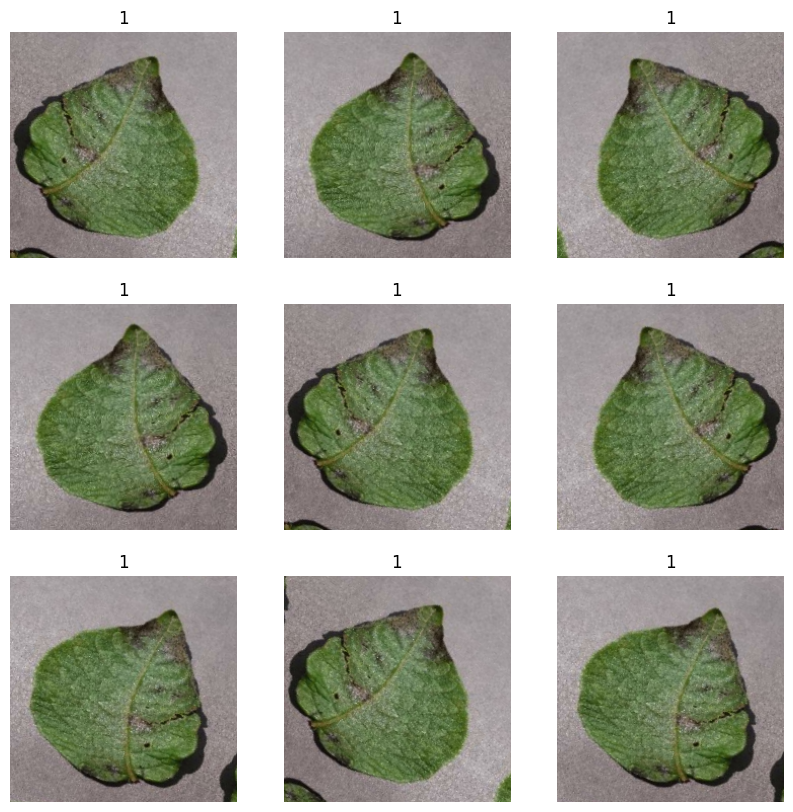

In [ ]:
import numpy as np

for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
base_model = keras.applications.MobileNetV2 (
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
nb_classes = 3
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = Dense(nb_classes, activation="softmax")(x)
#outputs = keras.layers.Dense(13)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer='adam' , loss='sparse_categorical_crossentropy',metrics =['accuracy']) 

In [ ]:
epochs = 30
history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

Epoch 1/30
58/58 [==============================] - 18s 98ms/step - loss: 0.4187 - accuracy: 0.8384 - val_loss: 0.1931 - val_accuracy: 0.9573
Epoch 2/30
58/58 [==============================] - 4s 73ms/step - loss: 0.1646 - accuracy: 0.9520 - val_loss: 0.1192 - val_accuracy: 0.9682
Epoch 3/30
58/58 [==============================] - 3s 57ms/step - loss: 0.1248 - accuracy: 0.9598 - val_loss: 0.1121 - val_accuracy: 0.9652
Epoch 4/30
58/58 [==============================] - 3s 57ms/step - loss: 0.1013 - accuracy: 0.9633 - val_loss: 0.0852 - val_accuracy: 0.9742
Epoch 5/30
58/58 [==============================] - 4s 74ms/step - loss: 0.0841 - accuracy: 0.9668 - val_loss: 0.0853 - val_accuracy: 0.9732
Epoch 6/30
58/58 [==============================] - 3s 58ms/step - loss: 0.0782 - accuracy: 0.9773 - val_loss: 0.0793 - val_accuracy: 0.9762
Epoch 7/30
58/58 [==============================] - 3s 58ms/step - loss: 0.0662 - accuracy: 0.9790 - val_loss: 0.0740 - val_accuracy: 0.9762
Epoch 8/30
5

In [ ]:
scores = model.evaluate(test_dataset)

51/51 [==============================] - 2s 29ms/step - loss: 0.0379 - accuracy: 0.9841


In [ ]:
class_names = test_dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 25ms/step


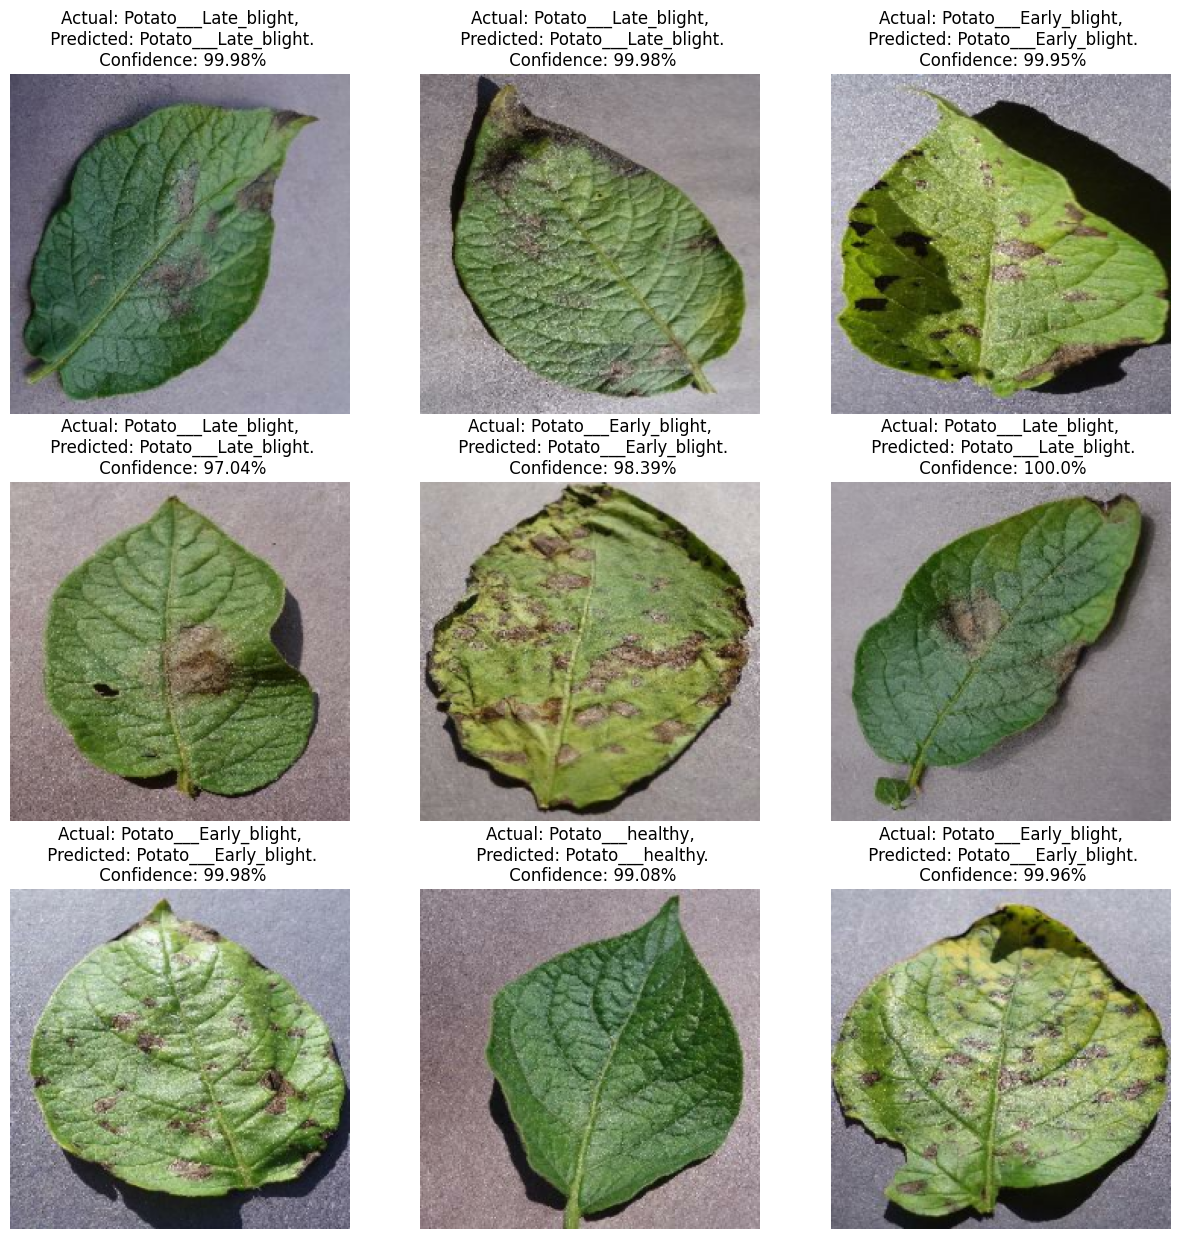

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")